<a href="https://colab.research.google.com/github/mgiorgi13/brain_tumor_classifier/blob/mattia/CLAHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLAHE experiments**  RIVEDERE !!!

In this Jupyter Notebook, we will use the CLAHE (Contrast Limited Adaptive Histogram Equalization) method to improve the contrast and quality of images. CLAHE is a histogram equalization technique that dynamically adapts the image contrast based on the local pixel distribution.

Our goal is to enhance the visibility and details of images in our medical image dataset, which includes different categories such as glioma_tumor, meningioma_tumor, no_tumor, and pituitary_tumor. We will utilize the OpenCV library to apply the CLAHE transformation to grayscale images.

The process involves creating a new folder named "clahe" in our dataset path. Within this folder, copies of the original images from their respective subfolders will be created, and the CLAHE transformation will be applied to these copies. The end result will be an improved version of the images with enhanced contrast and clearer details.

We will use the "apply_clahe" function to apply CLAHE to grayscale images. Subsequently, we will iterate through the different categories of images in the dataset (glioma_tumor, meningioma_tumor, no_tumor, and pituitary_tumor) and apply CLAHE to each image. The results will be saved in the "clahe" folder while maintaining the same subfolder structure as the original dataset.

The ultimate objective is to obtain enhanced images with optimized contrast, which can be used for training deep learning algorithms or for further analysis and research in the field of medical imaging.


# **Importing Libraries**

In this paragraph, we have imported the necessary libraries to create the CNN. TensorFlow and Keras are the main frameworks that we will use to create the convolutional neural network. Additionally, we have imported other useful libraries such as OpenCV (cv2) for image preprocessing, PIL for image manipulation, and Matplotlib for image visualization.

In [16]:
import pickle
from keras.models import load_model
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate, BatchNormalization
import os
import glob
import shutil
from sklearn.utils import shuffle
import zipfile
import cv2
import imutils
import random as rn
from sklearn.preprocessing import LabelBinarizer
from google.colab.patches import cv2_imshow
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import image_dataset_from_directory
from PIL import Image
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn import metrics

# **Google Drive connection**

Necessary to run the classifier

In [ ]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **CLAHE preprocessing**

Skip if it has already been done

In [ ]:
# Funzione per applicare la trasformazione CLAHE a un'immagine
def apply_clahe(image_path, output_path):
    image = cv2.imread(image_path, 0)  # Carica l'immagine in scala di grigi
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # Crea l'oggetto CLAHE
    clahe_image = clahe.apply(image)  # Applica la trasformazione CLAHE all'immagine
    cv2.imwrite(output_path, clahe_image)  # Salva l'immagine trasformata

## Training set clahe preprocessing

In [ ]:
dataset_path = "/content/drive/MyDrive/BrainTumorDataset/"

glioma_tumor_path = os.path.join(dataset_path, 'Preprocessed/Train/glioma_tumor/')
meningioma_tumor_path = os.path.join(dataset_path, 'Preprocessed/Train/meningioma_tumor/')
no_tumor_path = os.path.join(dataset_path, 'Preprocessed/Train/no_tumor/')
pituitary_tumor_path = os.path.join(dataset_path, 'Preprocessed/Train/pituitary_tumor/')

glioma_tumor_entries = os.listdir(glioma_tumor_path)
meningioma_entries = os.listdir(meningioma_tumor_path)
no_tumor_entries = os.listdir(no_tumor_path)
pituitary_tumor_entries = os.listdir(pituitary_tumor_path)

output_path = os.path.join(dataset_path, 'Preprocessed/CLAHE/')
os.makedirs(output_path, exist_ok=True)

In [ ]:
# Elabora le immagini nella cartella glioma_tumor
for entry in glioma_tumor_entries:
    image_path = os.path.join(glioma_tumor_path, entry)
    output_subfolder = os.path.join(output_path, 'Train/glioma_tumor/')
    os.makedirs(output_subfolder, exist_ok=True)
    output_image_path = os.path.join(output_subfolder, entry)
    apply_clahe(image_path, output_image_path)

# Elabora le immagini nella cartella meningioma_tumor
for entry in meningioma_entries:
    image_path = os.path.join(meningioma_tumor_path, entry)
    output_subfolder = os.path.join(output_path, 'Train/meningioma_tumor/')
    os.makedirs(output_subfolder, exist_ok=True)
    output_image_path = os.path.join(output_subfolder, entry)
    apply_clahe(image_path, output_image_path)

# Elabora le immagini nella cartella no_tumor
for entry in no_tumor_entries:
    image_path = os.path.join(no_tumor_path, entry)
    output_subfolder = os.path.join(output_path, 'Train/no_tumor/')
    os.makedirs(output_subfolder, exist_ok=True)
    output_image_path = os.path.join(output_subfolder, entry)
    apply_clahe(image_path, output_image_path)

# Elabora le immagini nella cartella pituitary_tumor
for entry in pituitary_tumor_entries:
    image_path = os.path.join(pituitary_tumor_path, entry)
    output_subfolder = os.path.join(output_path, 'Train/pituitary_tumor/')
    os.makedirs(output_subfolder, exist_ok=True)
    output_image_path = os.path.join(output_subfolder, entry)
    apply_clahe(image_path, output_image_path)


## Validation set clahe preprocessing

In [ ]:
dataset_path = "/content/drive/MyDrive/BrainTumorDataset/"

glioma_tumor_path = os.path.join(dataset_path, 'Preprocessed/Validation/glioma_tumor/')
meningioma_tumor_path = os.path.join(dataset_path, 'Preprocessed/Validation/meningioma_tumor/')
no_tumor_path = os.path.join(dataset_path, 'Preprocessed/Validation/no_tumor/')
pituitary_tumor_path = os.path.join(dataset_path, 'Preprocessed/Validation/pituitary_tumor/')

glioma_tumor_entries = os.listdir(glioma_tumor_path)
meningioma_entries = os.listdir(meningioma_tumor_path)
no_tumor_entries = os.listdir(no_tumor_path)
pituitary_tumor_entries = os.listdir(pituitary_tumor_path)

output_path = os.path.join(dataset_path, 'Preprocessed/CLAHE/')
os.makedirs(output_path, exist_ok=True)

In [ ]:
# Elabora le immagini nella cartella glioma_tumor
for entry in tqdm(glioma_tumor_entries):
    image_path = os.path.join(glioma_tumor_path, entry)
    output_subfolder = os.path.join(output_path, 'Validation/glioma_tumor/')
    os.makedirs(output_subfolder, exist_ok=True)
    output_image_path = os.path.join(output_subfolder, entry)
    apply_clahe(image_path, output_image_path)

# Elabora le immagini nella cartella meningioma_tumor
for entry in tqdm(meningioma_entries):
    image_path = os.path.join(meningioma_tumor_path, entry)
    output_subfolder = os.path.join(output_path, 'Validation/meningioma_tumor/')
    os.makedirs(output_subfolder, exist_ok=True)
    output_image_path = os.path.join(output_subfolder, entry)
    apply_clahe(image_path, output_image_path)

# Elabora le immagini nella cartella no_tumor
for entry in tqdm(no_tumor_entries):
    image_path = os.path.join(no_tumor_path, entry)
    output_subfolder = os.path.join(output_path, 'Validation/no_tumor/')
    os.makedirs(output_subfolder, exist_ok=True)
    output_image_path = os.path.join(output_subfolder, entry)
    apply_clahe(image_path, output_image_path)

# Elabora le immagini nella cartella pituitary_tumor
for entry in tqdm(pituitary_tumor_entries):
    image_path = os.path.join(pituitary_tumor_path, entry)
    output_subfolder = os.path.join(output_path, 'Validation/pituitary_tumor/')
    os.makedirs(output_subfolder, exist_ok=True)
    output_image_path = os.path.join(output_subfolder, entry)
    apply_clahe(image_path, output_image_path)


100%|██████████| 180/180 [00:47<00:00,  3.81it/s]


# **Utilities**

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras import backend as K
from itertools import cycle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score

dataset_path = "/content/drive/MyDrive/BrainTumorDataset"

# Percorso della cartella "unified" che contiene le sottocartelle delle classi
base_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Unified"

# Definisci i percorsi per il set di test, di validazione e di addestramento
test_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Test"
val_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/CLAHE/Validation"
train_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/CLAHE/Train"

models_path = "/content/drive/MyDrive/BrainTumorDataset/Models/CLAHE"
cnn_results_path = os.path.join(models_path, 'CNN')
vgg16_results_path = os.path.join(models_path, 'VGG16')
resnet50_results_path = os.path.join(models_path, 'ResNet50')
inceptionv3_results_path = os.path.join(models_path, 'InceptionV3')
# actual_results_path = vgg16_results_path

def set_seed ():
	''' 
	set_seed is used to obtain reproducible results using keras during the development phase
	'''
	seed = 10
	# The below is necessary for reproducible results of certain Python hash-based operations.
	os.environ["PYTHONHASHSEED"]="0"
	# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
	np.random.seed(seed)
	# The below is necessary for starting core Python generated random numbers in a well-defined state.
	rn.seed(seed)
	# The below tf.random.set_seed will make x number generation in TensorFlow have a well-defined initial state.
	tf.random.set_seed(seed)     

# Definisci le dimensioni delle immagini
image_size = 224
batch_size = 32

# Crea un oggetto ImageDataGenerator per il preprocessing delle immagini
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Carica le immagini dal set di addestramento
train_generator = data_generator.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Carica le immagini dal set di test
test_generator = data_generator.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Carica le immagini dal set di validazione
val_generator = data_generator.flow_from_directory(
    val_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)
     

def show_training_and_validation_performance(history,path):
	'''
	show_training_and_validation_performance is used to plot the performances during the training phase
	:param history: object in which are recorded all the events
	'''
	acc = history.history['accuracy']
	val_acc = history.history['val_accuracy']
	loss = history.history['loss']
	val_loss = history.history['val_loss']

	epochs = range(len(acc))

	plt.plot(epochs, acc, 'bo', label='Training accuracy')
	plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
	plt.title('Training and validation accuracy')
	plt.legend()

	plt.figure()

	plt.plot(epochs, loss, 'bo', label='Training loss')
	plt.plot(epochs, val_loss, 'b', label='Validation loss')
	plt.title('Training and validation loss')
	plt.legend()

	plt.savefig(path)

	plt.show()

def compile_model (model, optimizer='adam', learning_rate = 0.001):
	'''
	compile_model is used to compile the current model
	:param model: model to compile
	:param optimizer: optimizer to be used
	:param learning_rate: learning rate parameter for the optimizer
	'''
	if optimizer == 'adam':
		model.compile(loss="categorical_crossentropy",
		optimizer=optimizers.Adam(learning_rate=learning_rate),
		metrics=["accuracy"])
	elif optimizer == 'rmsprop':
		model.compile(loss="categorical_crossentropy",
					optimizer = optimizers.RMSprop(learning_rate=learning_rate),
					metrics=['accuracy'])
	model.summary()

def run_model (model, type, model_name, epochs = 100, patience=5, monitor='val_loss'):
	'''
	run_model is used to run the current mode
	:param model: model to run
	:param model_name: name given to save the model
	:param type: type of model, CNN, VGG16, ResNet50, InceptionV3
	:param epochs: how many epochs to do
	:param patience: patience value for Early Stopping
	:param monitor: what to monitor for Early Stopping and Model Checkpoint
	'''
	# local save path for the models
	save_path = os.path.join(models_path, type + '/' + model_name + '.h5') 
	callbacks_list = [
					keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
					keras.callbacks.ModelCheckpoint(
						filepath = save_path,
						monitor=monitor,
						verbose=1,
						save_best_only=True)
					]
	history = model.fit(train_generator,
						epochs=epochs,
						validation_data=val_generator,
						callbacks=callbacks_list)
	# save on Drive only the best model
	show_training_and_validation_performance(history,os.path.join(models_path, type + '/' + model_name + '_validation.png'))

def plot_roc_curve(y_true, y_pred, n_classes, class_labels, model_name, type):

    # Converti le etichette di classe in formato binario
    lb = LabelBinarizer()
    y_true_binary = lb.fit_transform(y_true)

    # Calcola i tassi di FPR e TPR per ogni classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_true_binary[:, i], y_pred[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    plt.figure()
    colors = ['blue', 'red', 'green', 'orange']  # Colori per le diverse classi

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, label='ROC curve {0} ({1:0.2f}%)'.format(class_labels[i], roc_auc[i]*100))

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(models_path, type + '/' + model_name + '_ROC.png'))
    plt.show()

def evaluate_model (model, test_generator, model_name, type):
	'''
	evaluate_model is used to plot some statistics about the performance on the test set
	:param model: model to consider
	'''
	labels_d= ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

	# get predictions
	y_score = model.predict(test_generator)
	# convert predictions to classes
	y_pred = np.argmax(y_score, axis=-1)
	# get true classes
	y_true = test_generator.classes
	# extract class labels
	class_labels = list(test_generator.class_indices.keys())
	
	print("Classification report: ")
	# create and show classification report
	print(metrics.classification_report(y_true, y_pred, target_names=class_labels,digits = 4))
	# save classification report
	with open(os.path.join(models_path, type + '/' + model_name + '_classification_report.txt'), 'w') as f:
		f.write(metrics.classification_report(y_true, y_pred, target_names=class_labels,digits = 4))

	# create and show confusion matrix	
	cm = confusion_matrix(y_true, y_pred)	
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
	disp.plot(xticks_rotation=45)
	
	# save confusion matrix
	plt.savefig(os.path.join(models_path, type, model_name + '_confusion_matrix.png'), bbox_inches='tight', pad_inches=0.1)
	plt.show()

	plot_roc_curve(y_true, y_score, 4, class_labels, model_name, type)

def get_index_by_layer_name(model, layer_name):
  '''
  get_index_by_layer_name is used to retrieve the index of a specific layer
  :param model: model to check
  :param layer_name: name of the layer we want to get the index of
  :return: the index of the layer named as defined in layer_name
  '''
  for index, layer in enumerate(model.layers):
      if layer.name == layer_name:
          return index 

def clear(model):
	del model
	K.clear_session() 

set_seed ()

Found 4520 images belonging to 4 classes.
Found 652 images belonging to 4 classes.
Found 652 images belonging to 4 classes.


Se il modello riesce ad apprendere correttamente, si dovrebbe osservare un andamento decrescente della loss e un andamento crescente dell'accuracy nel training set. Tuttavia, se la rete ha una capacità eccessiva rispetto al problema da risolvere, può incorrere in overfitting: in tal caso si ha un abbassamento della loss e un aumento dell'accuracy sul training set, ma un peggioramento delle performance sulla validation set (ovvero un aumento della validation loss e un abbassamento della validation accuracy).

# **CNN from scratch with clahe preprocessing**

## Exp 1

First CNN model with **one convolutional layer** and **one max pooling layer** at the biginning.

Than **one flatten layer** and **one dense layer** with 4 units (one for each class) and softmax activation function.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 250, 250, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 125, 125, 32)     0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 500000)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2000004   
                                                                 
Total params: 2,000,900
Trainable params: 2,000,900
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 1.1549 - accuracy: 0.6471
Epoch 1: val_

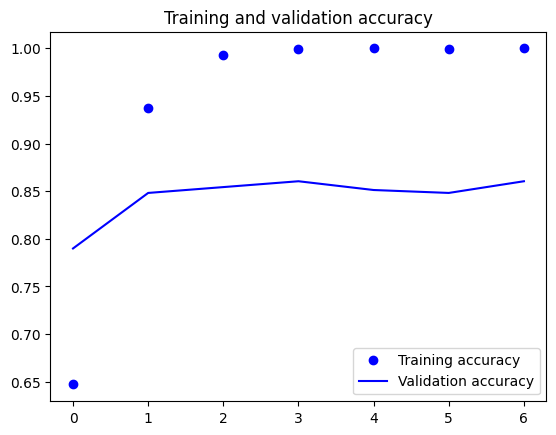

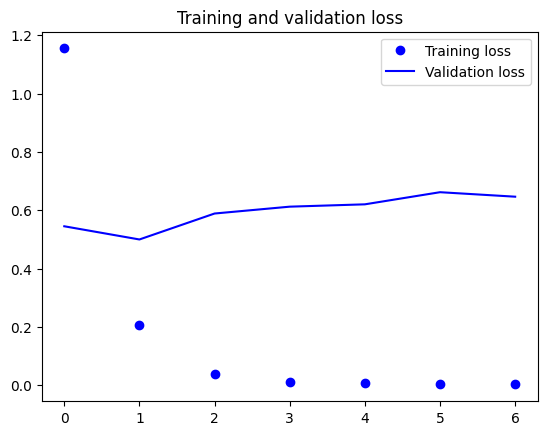

21/21 [==============================] - 4s 165ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.7772    0.8486    0.8114       185
meningioma_tumor     0.7740    0.7326    0.7527       187
        no_tumor     0.8131    0.8700    0.8406       100
 pituitary_tumor     0.9699    0.8944    0.9306       180

        accuracy                         0.8313       652
       macro avg     0.8336    0.8364    0.8338       652
    weighted avg     0.8350    0.8313    0.8320       652



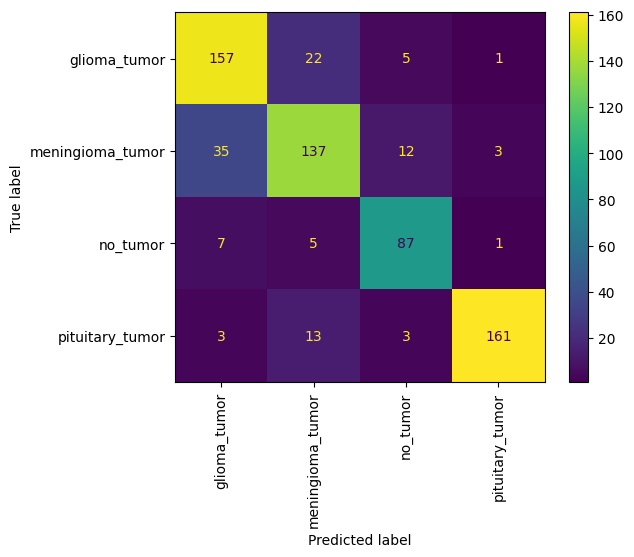

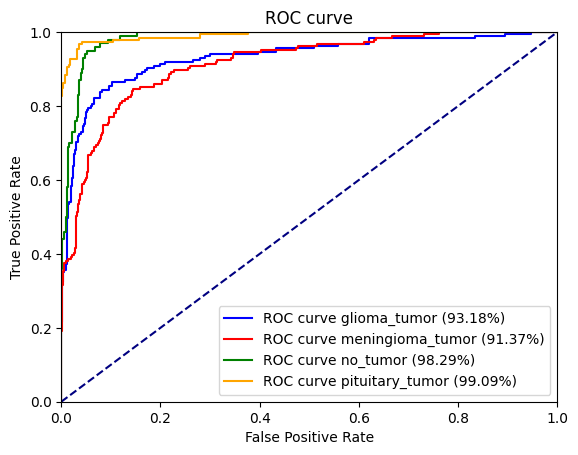

In [18]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_size, image_size, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(4, activation='softmax'))

compile_model(model)

run_model(model, 'CNN', 'cnn_from_scratch_clahe_exp1')

evaluate_model(model,test_generator, 'cnn_from_scratch_clahe_exp1', 'CNN')

## Exp 2

Second CNN model with **three convolutional layers** and **three max pooling layers** at the biginning.

Than **one flatten layer** and **one dense layer** with 256 units and softmax activation function.

We add a **dropout layer** with 0.5 probability to avoid overfitting.

At the end we add a **dense layer** with 4 units (one for each class) and softmax activation function.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_size, image_size, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((3, 3)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((4, 4)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

compile_model(model)

run_model(model, 'CNN','cnn_from_scratch_clahe_exp2')

evaluate_model(model,test_generator, 'cnn_from_scratch_clahe_exp2', 'CNN')

## Exp 3

Third CNN model with **four convolutional layers** and **four max pooling layers** at the biginning.

Each of the max pooling layer have a **different pool size**.

Than **one flatten layer** and **one dense layer** with 256 units and softmax activation function.

We add a **dropout layer** with 0.5 probability to avoid overfitting.

At the end we add a **dense layer** with 4 units (one for each class) and softmax activation function. 

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_size, image_size, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((3, 3)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((4, 4)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((5, 5)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

compile_model(model)

run_model(model, 'CNN', 'cnn_from_scratch_clahe_exp3')

evaluate_model(model,test_generator, 'cnn_from_scratch_clahe_exp3', 'CNN')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 250, 250, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 125, 125, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 41, 41, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 10, 10, 128)     

## Exp 8

Eighth CNN model with four convolutional layers and four max pooling layers at the biginning.

Now each of the max pooling layer have a different pool size.

Than one flatten layer and one dense layer with 512 units and softmax activation function.

We add a dropout layer with 0.5 probability to avoid overfitting.

At the end we add a dense layer with 4 units (one for each class) and softmax activation function.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_size, image_size, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((3, 3)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((4, 4)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((5, 5)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

compile_model(model)

run_model(model, 'CNN', 'cnn_from_scratch_clahe_exp8')

evaluate_model(model,test_generator, 'cnn_from_scratch_clahe_exp8', 'CNN')

## Exp 9

Ninth CNN model with 3 convolutional layers and 3 max pooling layer at the biginning.


Now each of the max pooling layer have a different pool size.

Than one flatten layer and one dense layer with 512 units and softmax activation function.

Than one other dense layer with 256 units and softmax activation function.

We add a dropout layer with 0.5 probability to avoid overfitting.

At the end we add a dense layer with 4 units (one for each class) and softmax activation function.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_size, image_size, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((3, 3)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((4, 4)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((5, 5)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

compile_model(model)

run_model(model, 'CNN', 'cnn_from_scratch_clahe_exp9')

evaluate_model(model,test_generator, 'cnn_from_scratch_clahe_exp9', 'CNN')

## initial model

In [ ]:
# Definire un modello sequenziale di Keras
model = Sequential()

# Aggiungere un layer convoluzionale con 32 filtri, dimensione del kernel di 3x3, funzione di attivazione ReLU e padding "same"
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_size, image_size, 3)))

# Aggiungere un layer di max pooling con dimensione 2x2
model.add(MaxPooling2D((2, 2)))

# Aggiungere un altro layer convoluzionale con 64 filtri, dimensione del kernel di 3x3, funzione di attivazione ReLU e padding "same"
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

# Aggiungere un altro layer di max pooling con dimensione 2x2
model.add(MaxPooling2D((2, 2)))

# Aggiungere un altro layer convoluzionale con 128 filtri, dimensione del kernel di 3x3, funzione di attivazione ReLU e padding "same"
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

# Aggiungere un altro layer di max pooling con dimensione 2x2
model.add(MaxPooling2D((2, 2)))

# Aggiungere un layer di appiattimento per convertire l'output del layer precedente in un vettore unidimensionale
model.add(Flatten())

# Aggiungere un layer completamente connesso con 512 unità e funzione di attivazione ReLU
model.add(Dense(512, activation='relu'))

# Aggiungere un layer di dropout con una percentuale di dropout di 0,5
model.add(Dropout(0.5))

# Aggiungere un altro layer completamente connesso con 4 unità (una per ogni classe) e funzione di attivazione softmax
model.add(Dense(4, activation='softmax'))

compile_model(model)

run_model(model, 'CNN', 'cnn_from_scratch_initial_model_clahe')

evaluate_model(model,test_generator, 'cnn_from_scratch_initial_model_clahe', 'CNN')